In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
bank = pd.read_csv('https://raw.githubusercontent.com/christianolivamoya/MIAX11-ML/main/data/bank.csv', sep=';')
bank.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3101,44,blue-collar,married,primary,no,2657,yes,no,unknown,20,jun,202,2,-1,0,unknown,no
3393,49,technician,married,tertiary,no,279,yes,no,unknown,19,may,168,4,-1,0,unknown,no
1831,32,admin.,single,tertiary,no,-59,no,yes,unknown,4,jul,192,1,-1,0,unknown,no
3150,53,technician,married,secondary,no,9146,no,no,cellular,13,aug,136,4,-1,0,unknown,no
785,23,student,married,tertiary,yes,-230,yes,no,cellular,18,may,259,2,-1,0,unknown,no


Hacemos el preprocesado de los datos como hemos visto previamente.

In [4]:
bank.drop(columns=['day', 'month'], inplace=True)
educ_mapping = {'unknown':0,
                'primary':1,
                'secondary':2,
                'tertiary':3}
noyes_mapping = {'no':False, 'yes':True}
bank['education'].replace(educ_mapping, inplace=True)
bank['y'].replace(noyes_mapping, inplace=True) # Cambio el target a True (1) o False (0)
bank['default'].replace(noyes_mapping, inplace=True)
bank['housing'].replace(noyes_mapping, inplace=True)
bank['loan'].replace(noyes_mapping, inplace=True)

features = bank.drop(columns='y')
target = bank['y']

features = pd.get_dummies(features)
features.sample(5)

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3454,59,2,False,174,True,False,204,1,-1,0,...,True,False,False,False,False,True,False,False,False,True
1111,37,2,False,480,False,False,344,2,182,8,...,False,True,False,True,False,False,False,True,False,False
4216,53,2,False,459,False,False,317,6,192,1,...,False,True,False,True,False,False,False,False,True,False
2481,30,3,False,931,False,False,1183,1,-1,0,...,False,True,False,True,False,False,False,False,False,True
2263,58,2,False,502,True,False,197,2,370,3,...,False,True,False,True,False,False,True,False,False,False


Balanceamos las clases con UNDERSAMPLING

In [43]:
np.unique(target, return_counts=True)

(array([False,  True]), array([4000,  521]))

In [44]:
dataset_x = []
dataset_x.append(features.values[target==True])
dataset_x.append(features.values[target==False][:521])
dataset_x = np.concatenate(dataset_x)
dataset_x = pd.DataFrame(dataset_x, columns=features.columns)
dataset_y = np.array([True]*521 + [False]*521)
dataset_y = pd.Series(dataset_y, name="y")
dataset_x.shape, dataset_y.shape

((1042, 32), (1042,))

Separamos el dataset en train y test.

In [45]:
x_train, x_test, y_train, y_test = train_test_split(dataset_x,
                                                    dataset_y,
                                                    test_size=0.2,
                                                    random_state=20)

In [46]:
means = x_train.mean()
stds = x_train.std()
x_train = (x_train - means) / stds
x_test = (x_test - means) / stds

In [47]:
knn = KNeighborsClassifier(n_neighbors=5)
_ = knn.fit(x_train, y_train)

El accuracy de base.  Tomaremos este valor como referencia
respecto al cálculo de la importancia de características

In [48]:
print(knn.score(x_test, y_test))

0.6220095693779905


<hr>

## Importancia por Correlación

<Axes: >

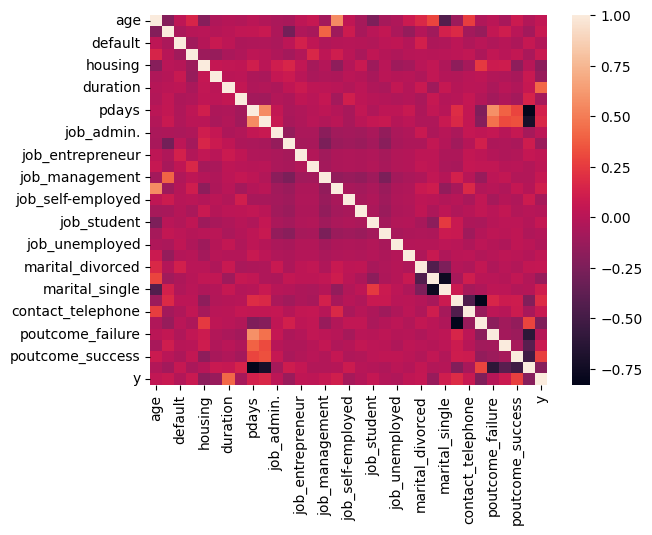

In [50]:
matriz_corr = pd.concat((x_train, y_train), axis=1).corr()
sns.heatmap(matriz_corr)

In [51]:
imp_corr = pd.concat((x_train, y_train), axis=1).corr()['y'][:-1]
imp_corr = imp_corr.abs().sort_values(ascending=False)
imp_corr

duration             0.417289
poutcome_success     0.264029
contact_unknown      0.239722
poutcome_unknown     0.202279
housing              0.183777
contact_cellular     0.179994
previous             0.157971
marital_married      0.131968
loan                 0.131673
job_blue-collar      0.122675
pdays                0.120971
job_retired          0.111131
marital_single       0.102449
poutcome_other       0.079862
job_self-employed    0.075663
campaign             0.074776
balance              0.071939
education            0.069540
contact_telephone    0.065197
job_management       0.056880
marital_divorced     0.055627
job_student          0.050292
age                  0.036451
job_unemployed       0.035713
job_entrepreneur     0.031992
job_unknown          0.031963
default              0.028352
job_housemaid        0.027049
job_technician       0.018769
job_services         0.016987
job_admin.           0.014309
poutcome_failure     0.013939
Name: y, dtype: float64

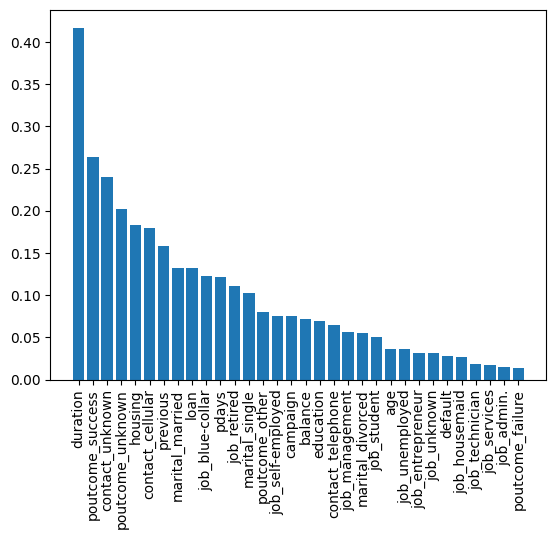

In [52]:
plt.bar(imp_corr.index, imp_corr)
plt.xticks(rotation=90)
plt.show()

In [62]:
lista_atributos = np.array(imp_corr.index[:5])
lista_atributos

array(['duration', 'poutcome_success', 'contact_unknown',
       'poutcome_unknown', 'housing'], dtype=object)

In [63]:
knn_corr = KNeighborsClassifier(n_neighbors=5)
knn_corr.fit(x_train[lista_atributos], y_train)
knn_corr.score(x_test[lista_atributos], y_test)

0.7990430622009569

In [64]:
# Comparamos con el base con todos los atributos y vemos que incluso ganamos un 1% de accuracy
knn.score(x_test, y_test)

0.6220095693779905

## Importancia por Permutación

In [65]:
from sklearn.inspection import permutation_importance

Calculamos la importancia de características por permutación utilizando
la función disponible en sklearn

In [66]:
# Tarda un rato (costoso computacionalmente para modelos lentos)
imp_perm = permutation_importance(knn, x_train, y_train, n_repeats=10)

In [67]:
imp_df = pd.DataFrame({'ft': x_train.columns,
                       'mean': imp_perm.importances_mean,
                       'std': imp_perm.importances_std
                      })
imp_df.sort_values('mean', ascending=False, inplace=True)
imp_df.head()

,ft,mean,std
6,duration,0.059784,0.006850
30,poutcome_success,0.016447,0.002792
10,job_admin.,0.013926,0.004498
0,age,0.012725,0.008163
9,previous,0.011285,0.002093


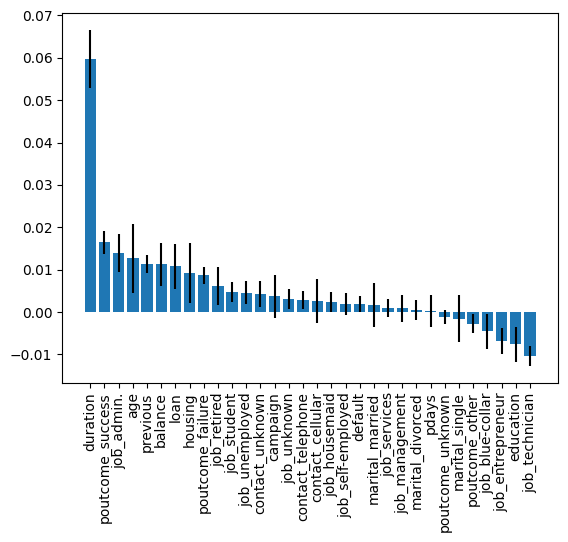

In [68]:
plt.bar(range(imp_df.shape[0]), imp_df["mean"], yerr=imp_df["std"], tick_label=imp_df["ft"])
plt.xticks(rotation=90)
plt.show()

In [69]:
lista_atributos = np.array(imp_df["ft"][:5])
lista_atributos

array(['duration', 'poutcome_success', 'job_admin.', 'age', 'previous'],
      dtype=object)

In [70]:
knn_perm = KNeighborsClassifier(n_neighbors=5)
knn_perm.fit(x_train[lista_atributos], y_train)
knn_perm.score(x_test[lista_atributos], y_test)

0.784688995215311

In [71]:
# Comparamos con el base con todos los atributos y vemos que incluso ganamos un 1% de accuracy
knn.score(x_test, y_test)

0.6220095693779905

## ¿Por qué?

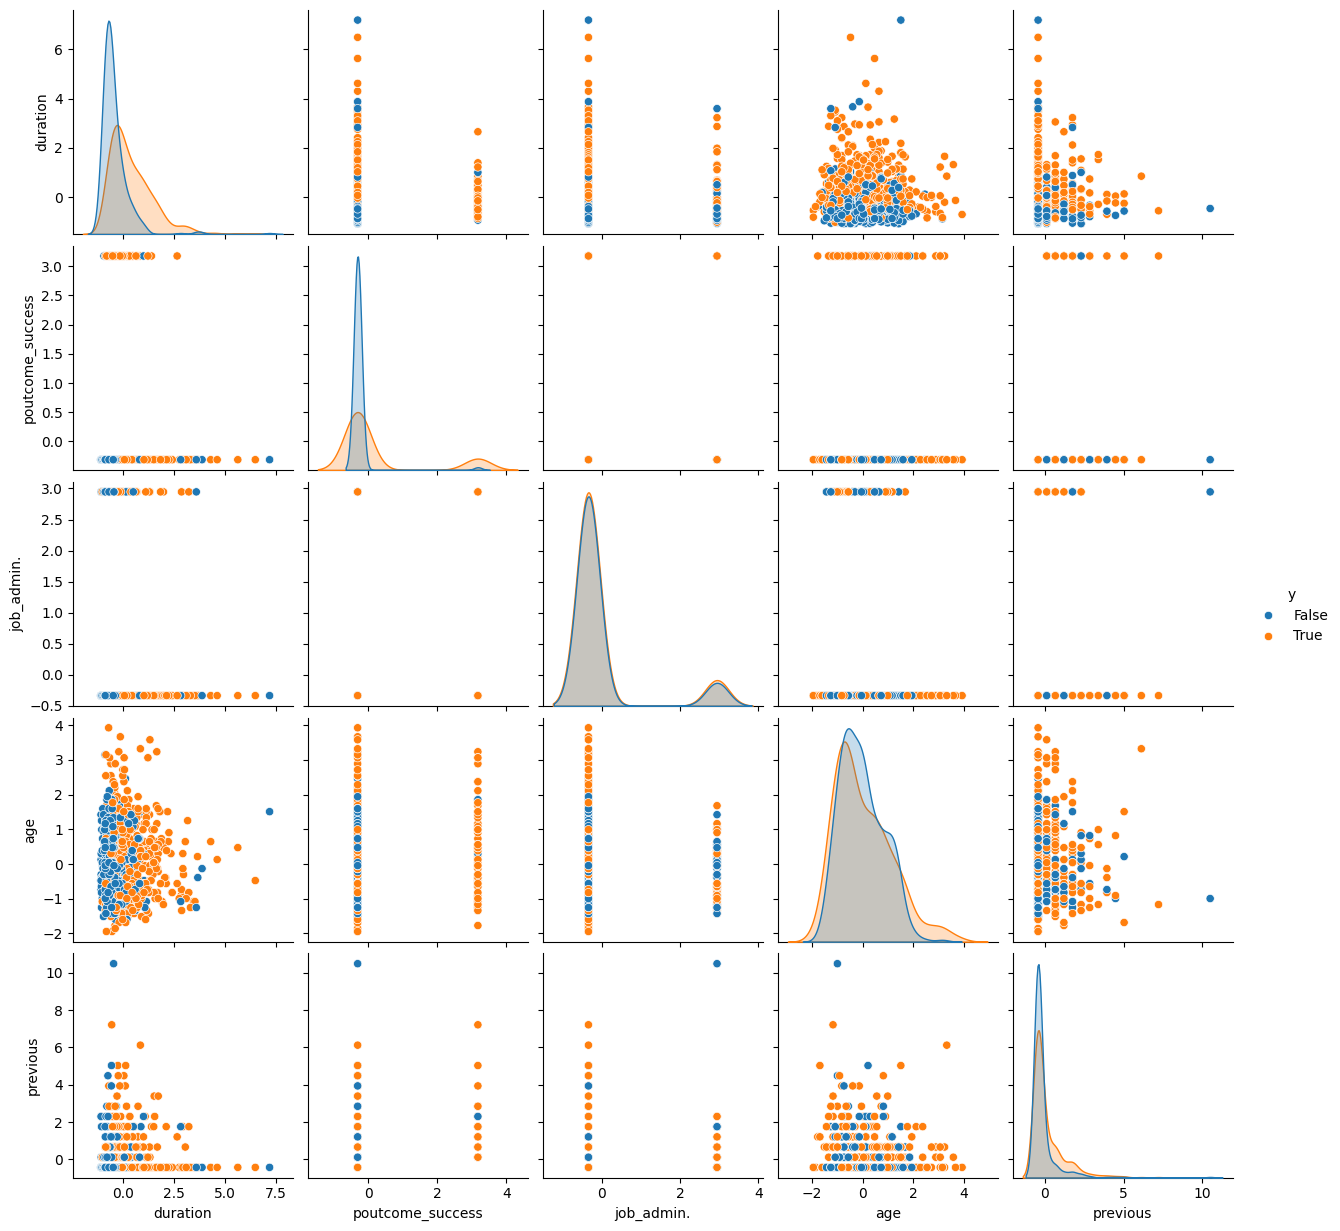

In [72]:
# AHORA SI
# Los datos tienen suficiente información con 5 atributos para que el modelo obtenga un 79% de accuracy
data = pd.concat((x_train[lista_atributos], y_train), axis=1)
sns.pairplot(data, hue="y")

## Curvas de accuracy

### Correlación

#### De menor a mayor importancia

In [81]:
scores = []
for K in range(1, len(features.columns)+1):
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(x_train[np.array(imp_corr.index)[-K:]], y_train)
  scores.append(knn.score(x_test[np.array(imp_corr.index)[-K:]], y_test))

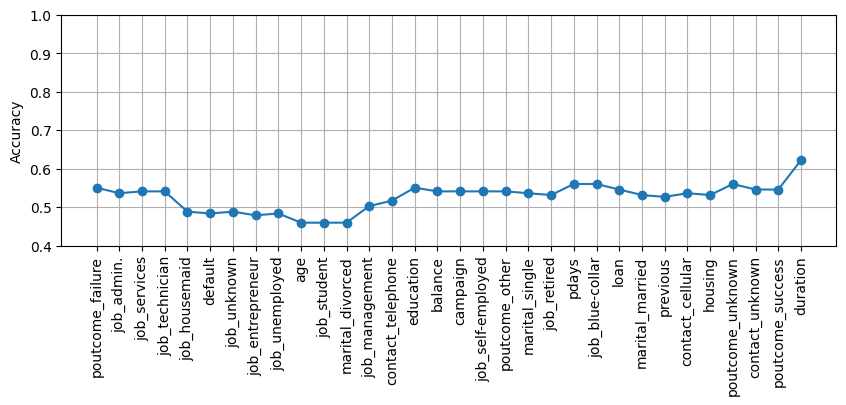

In [82]:
plt.figure(figsize=(10, 3))
plt.plot(scores, 'o-')
plt.xticks(range(len(features.columns)), np.array(imp_corr.index)[::-1], rotation=90)
plt.ylabel("Accuracy")
plt.grid()
plt.ylim(0.4, 1.0)
plt.show()

#### De mayor a menor importancia

In [83]:
scores = []
for K in range(1, len(features.columns)+1):
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(x_train[np.array(imp_corr.index)[:K]], y_train)
  scores.append(knn.score(x_test[np.array(imp_corr.index)[:K]], y_test))

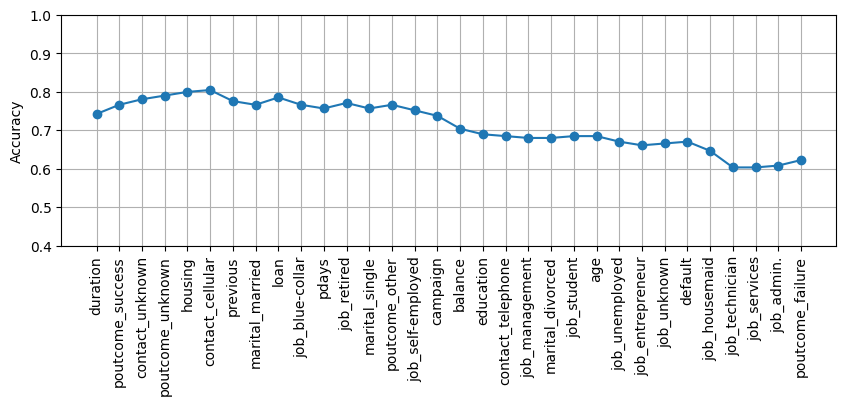

In [84]:
plt.figure(figsize=(10, 3))
plt.plot(scores, 'o-')
plt.xticks(range(len(features.columns)), np.array(imp_corr.index), rotation=90)
plt.ylabel("Accuracy")
plt.grid()
plt.ylim(0.4, 1.0)
plt.show()

### Permutación

#### De menor a mayor importancia

In [85]:
scores = []
for K in range(1, len(features.columns)+1):
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(x_train[np.array(imp_df.ft)[-K:]], y_train)
  scores.append(knn.score(x_test[np.array(imp_df.ft)[-K:]], y_test))

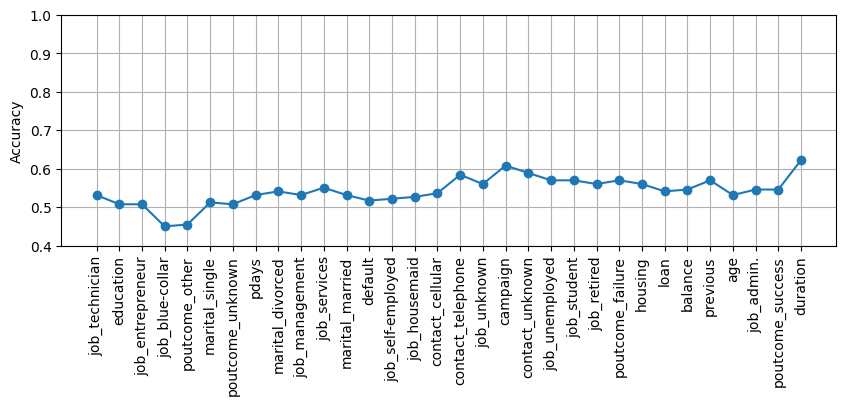

In [86]:
plt.figure(figsize=(10, 3))
plt.plot(scores, 'o-')
plt.xticks(range(len(features.columns)), np.array(imp_df.ft)[::-1], rotation=90)
plt.ylabel("Accuracy")
plt.grid()
plt.ylim(0.4, 1.0)
plt.show()

#### De mayor a menor importancia

In [87]:
scores = []
for K in range(1, len(features.columns)+1):
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(x_train[np.array(imp_df.ft)[:K]], y_train)
  scores.append(knn.score(x_test[np.array(imp_df.ft)[:K]], y_test))

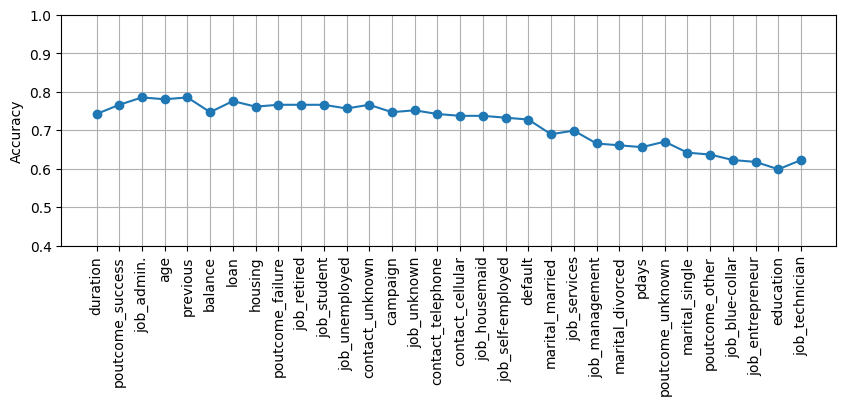

In [88]:
plt.figure(figsize=(10, 3))
plt.plot(scores, 'o-')
plt.xticks(range(len(features.columns)), np.array(imp_df.ft), rotation=90)
plt.ylabel("Accuracy")
plt.grid()
plt.ylim(0.4, 1.0)
plt.show()